# MNIST

Попробуем реализовать простую нейронную сеть без фрейморков типа PyTorch, используем лишь стандартные библиотеки типа NumPy

## Данные

Возьмём стандартный датасет MNIST

In [1]:
from sklearn.datasets import fetch_openml
import os
data_path = 'data/mnist'

os.makedirs(data_path, exist_ok=True)

# Загружаем MNIST с OpenML
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home=data_path)

print(X.shape)  
print(y.shape)

(70000, 784)
(70000,)


Теперь имеем датасет из 700000 изображений размером 28x28, которые вытянуты в вектор. Сперва преобразуем метки в стиле one-hot кодирования

In [2]:
import pandas as pd
import numpy as np

y_data = pd.Series(y).to_numpy().astype(int)
y = np.zeros((y_data.shape[0], np.max(y_data)+1))
y[np.arange(y_data.shape[0]), y_data] = 1

Сделаем модель с двумя полносвязными слоями. Пусть у нас есть вектор входных признаков размера $1 \times N$, матрица обучаемых весов $N \times K$ и вторая матрица $K \times 10$, где $10$ - количество классов (цифр). Также используем функции активации. После первого слоя исползуем ReLU, а после второго softmax, чтобы преобразовать выход нейронной сети в "уверенность" в выборе того или иного класса. Класс будет выбираться как максимум уверенности

### Функции активации

$\text{ReLU}(x) = \max(0, x)$

In [3]:
def relu(x : np.ndarray) -> np.ndarray:
    return np.maximum(x, 0.)

In [4]:
vec = np.random.randint(low=-10, high=20, size=(2, 30))
print("Исходный вектор")
print(vec)
print("Вектор после ReLU")
print(relu(vec))

Исходный вектор
[[ 18  -8  14  16  13   9   9   7  11   0  10   1   3  16   3  -5  -5  -8
   13  18  -9  19  -1 -10   4  -7  -7  13   7   8]
 [ 10  -9  16   7  15  14   8  17   2  -1  -8  -3   8  -3  16   6   9   6
   19  13   7 -10  -6   5   1  -2  -4  13  -5  18]]
Вектор после ReLU
[[18.  0. 14. 16. 13.  9.  9.  7. 11.  0. 10.  1.  3. 16.  3.  0.  0.  0.
  13. 18.  0. 19.  0.  0.  4.  0.  0. 13.  7.  8.]
 [10.  0. 16.  7. 15. 14.  8. 17.  2.  0.  0.  0.  8.  0. 16.  6.  9.  6.
  19. 13.  7.  0.  0.  5.  1.  0.  0. 13.  0. 18.]]


$\text{softmax}(x)_i = \dfrac{\exp(x_i)}{\sum\limits_j \exp(x_j)}$

In [5]:
def softmax(x: np.ndarray) -> np.ndarray:
    # x: (batch_size, num_classes)
    x_max = np.max(x, axis=-1, keepdims=True)  # (batch_size, 1)
    x_exp = np.exp(x - x_max)
    denom = np.sum(x_exp, axis=-1, keepdims=True)
    return x_exp / denom

In [6]:
vec = np.random.randint(low=-10, high=20, size=(2, 10))
print("Исходный вектор")
print(vec)
print("Вектор после ReLU")
res = softmax(vec)
print(res)
print("Проверка, что вычисления верны")
print(np.sum(res, axis=-1))

Исходный вектор
[[ 2 13 -3  0  8  9  8 19 -1  4]
 [ 1  7 -1 16  3  0  0  5 18 14]]
Вектор после ReLU
[[4.12937515e-08 2.47242793e-03 2.78235109e-10 5.58850155e-09
  1.66590883e-05 4.52840971e-05 1.66590883e-05 9.97448615e-01
  2.05589483e-09 3.05121846e-07]
 [3.58849303e-08 1.44770142e-05 4.85649721e-09 1.17308461e-01
  2.65155763e-07 1.32013281e-08 1.32013281e-08 1.95925081e-06
  8.66798797e-01 1.58759738e-02]]
Проверка, что вычисления верны
[1. 1.]


## Сама сеть

### Прямой проход

Также добавим сдвиг (bias) после применения каждой из полносвязных сетей

In [7]:
class Classifier:
    def __init__(self, input_size, k, output_size):
        self.fcl1 = np.random.randn(input_size, k)
        self.b1 = np.random.randn(k)
        self.fcl2 = np.random.randn(k, output_size)
        self.b2 = np.random.randn(output_size)
        
    def forward(self, x: np.ndarray) -> np.ndarray:
        h1 = x.dot(self.fcl1) + self.b1[np.newaxis, ...]
        z1 = relu(h1)
        h2 = z1.dot(self.fcl2) + self.b2[np.newaxis, ...]
        z2 = softmax(h2)
        return z2

### Обратный проход

Прежде чем считать обратное распространение ошибки, необходимо определить функцию потерь, которую мы будем минимизировать. Для многоклассовой классификации подходит перекрёстная энтропия:

$$
    \mathcal{L}(\vec{\hat{y}}, \vec{y}) = - \sum\limits_{i=1}^{k} y_i \ln(\hat{y}_i),
$$

где $\vec{\hat{y}}$ - вероятность выбора класса для каждого из классов (вектор длины 10), а $\vec{y}$ -- настоящая one-hot метка. Обучаться и считать ошибку мы будем на случайных наборах (батчах), поэтому ошибку нужно будет усреднять по всем предсказаниям

In [8]:
def loss(y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
    eps = 1e-12
    y_pred = np.clip(y_pred, eps, 1 - eps)
    res = -1 * np.sum((np.log(y_pred) * y_true), axis=-1)
    return np.mean(res)

Посмотрим, как будет изменяться градиент ошибки, используем цепное правило.

$$
    \dfrac{\partial \mathcal{L}}{\partial \hat{y}_i} = - \dfrac{y_i}{\hat{y}_i}
$$

$\vec{\hat{y}} = \text{softmax}(\vec{z})$

Теперь посчитаем

$$
    \dfrac{\partial \hat{y}_i}{\partial{z_j}}
$$

Два случая:

* $i = j$

$$
    \dfrac{\partial \hat{y}_i}{\partial{z_i}} = \dfrac{\partial}{\partial z_i} \dfrac{e^{z_i}}{\sum_k e^{z_k}} = \dfrac{e^{z_i} \sum_k e^{z_k} - e^{2z_i}}{\left( \sum_k e^{z_k} \right)^2} = \hat{y}_i (1 - \hat{y}_i)
$$

* $i \neq j$

$$
    \dfrac{\partial \hat{y}_i}{\partial{z_j}} = \dfrac{\partial}{\partial z_j} \dfrac{e^{z_i}}{\sum_k e^{z_k}} = - \dfrac{e^{z_i}}{\left( \sum_k e^{z_k} \right)^2} e^{z_j} = - \hat{y}_i \hat{y_j}
$$

Тогда градиент ошибки по логитам:

$$
    \dfrac{\partial\mathcal{L}}{\partial z_j} = \sum\limits_{i=1}^{K=10}\dfrac{\partial \mathcal{L}}{\partial \hat{y}_i} \dfrac{\partial \hat{y}_i}{\partial z_j} = - \sum\limits_{i=1}^{K=10} \dfrac{y_i}{\hat{y}_i}\dfrac{\partial \hat{y}_i}{\partial z_j}
$$

Разобьём сумму на те два 

$$
    \dfrac{\partial\mathcal{L}}{\partial z_j} = - \dfrac{y_j}{\hat{y}_j} \hat{y}_j (1 - \hat{y}_j) + \sum\limits_{i\neq j}^{K} \dfrac{y_i}{\hat{y}_i} \hat{y}_j \hat{y}_i = (\hat{y}_j - 1)y_j + \hat{y}_j \sum\limits_{i\neq j}^{K} y_i
$$

Если $\sum\limits_{i=1}^K y_i = 1$, то $\sum\limits_{i \neq j}^K y_i = 1 - y_j$

$$
    \dfrac{\partial\mathcal{L}}{\partial z_j} = (\hat{y}_j - 1)y_j + \hat{y}_j (1 - y_j) = \hat{y}_j y_j - y_j + \hat{y}_j - \hat{y}_j y_j = \hat{y}_j - y_j
$$

Получается, что это просто разность двух векторов: one-hot метки и нашего предсказания. Градиент по логитам это разность двух векторов, теперь надо найти градиенты для $W_2$ и $b_2$


$$
    z = h W_2 + b_2
$$

Сперва найдём градиент по $b_2$, он довольно простой:

$$
    \dfrac{\partial z_i}{\partial b_{2j}} = \delta_{ij},
$$

где $\delta_{ij}$ - символ Кронекера, то есть градиент по $z$ преобразуется в градиент по $b_2$ тождественным преобразованием и просто равен градиенту по $z$

$$
    \nabla_{b_2} \mathcal{L} = \nabla_z \mathcal{L}
$$

Теперь нам нужно посчитать производную по $W_2$. Производная от $h W$ по $W$ равна просто $h$, чтобы преобразовать градиент по $z$ в градиент по $W$, необходимо умножить на сопряжённую производную, то есть $$\nabla_{W_2} \mathcal{L} = h^{T} \nabla_z \mathcal{L}$$

Осталось посчитать производные по $W_1$ и $b_1$, напомним, что $h = \text{ReLU}\left( XW_1 + b_1 \right)$. Производная ReLU считается поэлементно и это просто маска: если элемент больше нуля, то этот элемент производной равен 1, если меньше либо равен нуля, то равен 0. 

$$
    \text{ReLU}'(x) = 
    \begin{cases}
        1, x > 0 \\
        0, x \leq 0
    \end{cases}
$$

Производная $z$ по $h$ это $W_2$, значит $\nabla_{h} \mathcal{L} = (\nabla_z \mathcal{L}) W_2^T$, который мы умножаем поэлементно на производную от ReLU (Обозначим как маску $M$): $M \odot (\nabla_z \mathcal{L}) W_2^T$. Градиент по b_1 опять не изменяется и равен 
$$\nabla_{b_1} \mathcal{L} = M \odot (\nabla_z \mathcal{L}) W_2^T$$

И наконец градиент по $W_1$ аналогично градиенту по $W_2$:

$$
    \nabla_{W_1} \mathcal{L} = X^T \left( M \odot (\nabla_z \mathcal{L}) W_2^T \right)
$$

Теперь мы можем всё это реализовать в коде, но необходимо модифицировать класс нейронной сети, чтобы она могла запомнить промежуточные вычисления между слоями. Также не забудем сделать усреднение по батчу (по первой оси)

In [9]:
class Classifier:
    def __init__(self, input_size, k, output_size, lr=3e-4):
        self.fcl1 = np.random.randn(input_size, k)
        self.b1 = np.random.randn(k)
        self.fcl2 = np.random.randn(k, output_size)
        self.b2 = np.random.randn(output_size)
        self.lr = lr
        
    def forward(self, x: np.ndarray, train = True) -> np.ndarray:
        if train:
            self.X = x
        h = x.dot(self.fcl1) + self.b1#[np.newaxis, ...]
        if train:
            self.M = h > 0
            self.M = self.M.astype(int)
        h = relu(h)
        if train:
            self.h = np.copy(h)
            self.W_2 = np.copy(self.fcl2)
        z = h.dot(self.fcl2) + self.b2#[np.newaxis, ...]
        z = softmax(z)
        return z
    
    def backprop(self, y_pred, y_true):
        dz = y_pred - y_true
        if len(dz.shape) > 2:
            dz = np.squeeze(dz)
        batch_size = dz.shape[0]
        db_2 = np.mean(dz, axis=0)
        dW_2 = self.h.T.dot(dz) / batch_size
        dh_masked = self.M * (dz.dot(self.W_2.T))
        db_1 = np.mean(dh_masked, axis=0)
        dW_1 = self.X.T.dot(dh_masked) / batch_size
        self.update_weights(dW_1, db_1, dW_2, db_2)
        
    def update_weights(self, dW_1, db_1, dW_2, db_2):
        self.fcl1 = self.fcl1 - self.lr * dW_1
        self.b1 = self.b1 - self.lr * db_1
        self.fcl2 = self.fcl2 - self.lr * dW_2
        self.b2 = self.b2 - self.lr * db_2
        
    def reset(self):
        self.X = None
        self.M = None
        self.h = None
        self.W_2 = None        
        

Теперь можем попробовать обучить нашу модель на случайном батче

In [10]:
X = X.to_numpy()

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
np.random.seed(0)
def get_batches(X, y, batch_size):
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        batch_indices = indices[start_idx:end_idx]
        yield X[batch_indices], y[batch_indices]

In [14]:
from tqdm import tqdm

In [15]:
batch_size = 32
cls = Classifier(input_size=X.shape[1], k=20, output_size=10, lr=3e-4)
train_loss = []
test_loss = []

for X_batch, y_batch in tqdm(get_batches(X_train, y_train, batch_size)):
    # 1. Прямой проход на батче (train=True)
    y_pred = cls.forward(X_batch, train=True)
    train_loss.append(loss(y_pred, y_batch))
    # 2. Обратный проход
    cls.backprop(y_pred, y_batch)
    # 3. Прямой проход на тесте (train=False)
    test_loss.append(loss(cls.forward(X_test, train=False), y_test))


1750it [01:11, 24.60it/s]


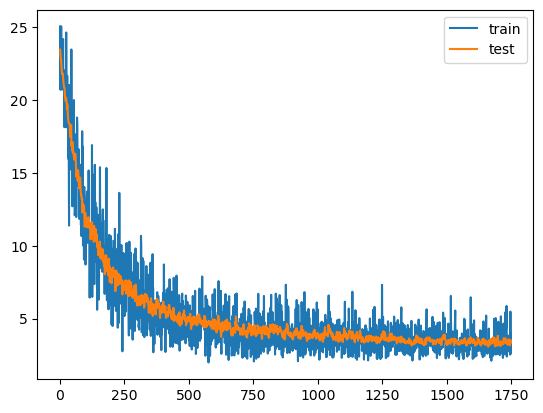

In [16]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(train_loss)), train_loss, label='train')
plt.plot(np.arange(len(test_loss)), test_loss, label='test')
plt.legend()
plt.show()